In [1]:
import pandas as pd

In [2]:
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.random_projection import SparseRandomProjection
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.datasets import load_digits
from sklearn.metrics.pairwise import euclidean_distances



In [3]:
# Save the cvs as a dataframe and remove the rows with null variety
df = pd.read_csv('stopword_filtered.csv')
df = df.dropna(subset=['variety'])
df.isnull().any()

Unnamed: 0     False
_c0            False
country         True
description    False
variety        False
Words          False
filtered       False
dtype: bool

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
count_vect = CountVectorizer()
tfidf = TfidfTransformer()
cv = CountVectorizer().fit_transform(df.filtered)
bagofwords = tfidf.fit_transform(cv)

In [6]:
data = df.values
data[0][4]
y = data[:,4]
from sklearn.preprocessing import LabelEncoder

# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y)
encoded_y = label_encoder.transform(y)
from keras.utils import to_categorical

# Step 2: One-hot encoding
one_hot_y = to_categorical(encoded_y)
len(one_hot_y[0])

/Users/janakidevikora/anaconda3/envs/PythonData/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


47

In [7]:
one_hot_y.shape

(103320, 47)

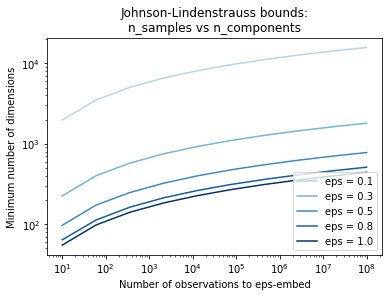

In [8]:
# Part 1: plot the theoretical dependency between n_components_min and
# n_samples

# range of admissible distortions
eps_range = np.linspace(0.1, 0.99, 5)
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(eps_range)))

# range of number of samples (observation) to embed
n_samples_range = np.logspace(1, 8, 10)

plt.figure()
for eps, color in zip(eps_range, colors):
    min_n_components = johnson_lindenstrauss_min_dim(n_samples_range, eps=eps)
    plt.loglog(n_samples_range, min_n_components, color=color)

plt.legend(["eps = %0.1f" % eps for eps in eps_range], loc="lower right")
plt.xlabel("Number of observations to eps-embed")
plt.ylabel("Minimum number of dimensions")
plt.title("Johnson-Lindenstrauss bounds:\nn_samples vs n_components")

plt.show()

In [9]:
# range of number of samples (observation) to embed
n_samples_range = np.int32(np.linspace(1, 10000, 20))

In [10]:
n_samples_range

array([    1,   527,  1053,  1579,  2106,  2632,  3158,  3684,  4211,
        4737,  5263,  5789,  6316,  6842,  7368,  7894,  8421,  8947,
        9473, 10000], dtype=int32)

In [11]:
np.linspace(0.01, 0.99, 100)

array([0.01      , 0.01989899, 0.02979798, 0.03969697, 0.04959596,
       0.05949495, 0.06939394, 0.07929293, 0.08919192, 0.09909091,
       0.1089899 , 0.11888889, 0.12878788, 0.13868687, 0.14858586,
       0.15848485, 0.16838384, 0.17828283, 0.18818182, 0.19808081,
       0.2079798 , 0.21787879, 0.22777778, 0.23767677, 0.24757576,
       0.25747475, 0.26737374, 0.27727273, 0.28717172, 0.29707071,
       0.3069697 , 0.31686869, 0.32676768, 0.33666667, 0.34656566,
       0.35646465, 0.36636364, 0.37626263, 0.38616162, 0.39606061,
       0.4059596 , 0.41585859, 0.42575758, 0.43565657, 0.44555556,
       0.45545455, 0.46535354, 0.47525253, 0.48515152, 0.49505051,
       0.50494949, 0.51484848, 0.52474747, 0.53464646, 0.54454545,
       0.55444444, 0.56434343, 0.57424242, 0.58414141, 0.5940404 ,
       0.60393939, 0.61383838, 0.62373737, 0.63363636, 0.64353535,
       0.65343434, 0.66333333, 0.67323232, 0.68313131, 0.6930303 ,
       0.70292929, 0.71282828, 0.72272727, 0.73262626, 0.74252

In [12]:
bagofwords.shape

(103320, 28129)

In [13]:
one_hot_y.shape

(103320, 47)

In [14]:
import pandas as pd

# Part 2: perform sparse random projection 

n_samples, n_features = bagofwords[:5000].shape
print("Embedding %d samples with dim %d using various random projections"
      % (n_samples, n_features))



Embedding 5000 samples with dim 28129 using various random projections


In [15]:
n_components_range = np.array([300, 1000, 10000])
dists = euclidean_distances(bagofwords[:5000], squared=True).ravel()

# select only non-identical samples pairs
nonzero = dists != 0
dists = dists[nonzero]



Projected 5000 samples from 28129 to 300 in 0.230s
Mean distances rate: 0.97 (0.17)
Projected 5000 samples from 28129 to 1000 in 1.150s
Mean distances rate: 0.99 (0.09)
Projected 5000 samples from 28129 to 10000 in 6.333s
Mean distances rate: 1.00 (0.03)


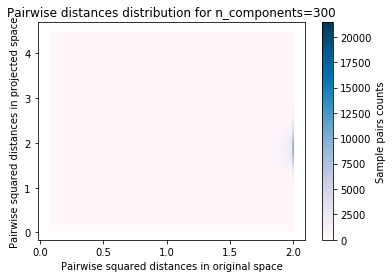

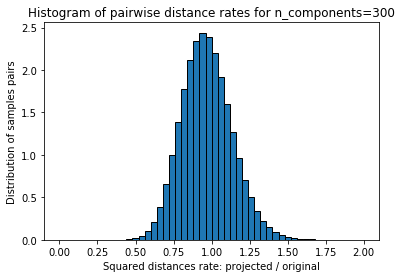

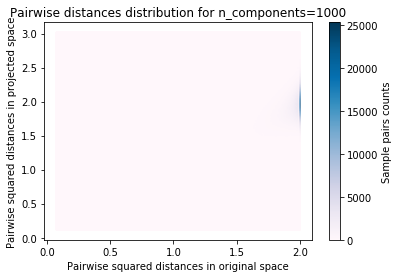

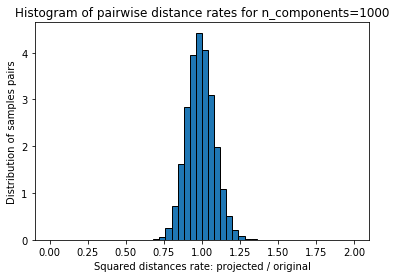

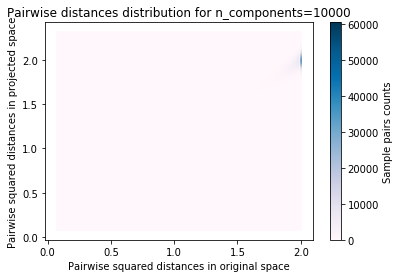

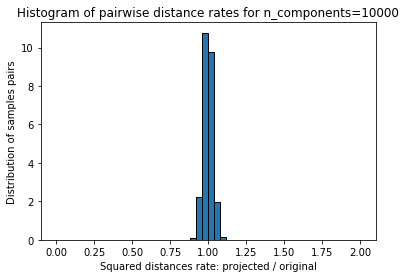

In [17]:
for n_components in n_components_range:
    t0 = time()
    rp = SparseRandomProjection(n_components=n_components)
    projected_data = rp.fit_transform(bagofwords[:5000])
    print("Projected %d samples from %d to %d in %0.3fs"
          % (n_samples, n_features, n_components, time() - t0))
    

    projected_dists = euclidean_distances(
        projected_data, squared=True).ravel()[nonzero]

    plt.figure()
    plt.hexbin(dists, projected_dists, gridsize=1000, cmap=plt.cm.PuBu)
    plt.xlabel("Pairwise squared distances in original space")
    plt.ylabel("Pairwise squared distances in projected space")
    plt.title("Pairwise distances distribution for n_components=%d" %
              n_components)
    cb = plt.colorbar()
    cb.set_label('Sample pairs counts')

    rates = projected_dists / dists
    print("Mean distances rate: %0.2f (%0.2f)"
          % (np.mean(rates), np.std(rates)))

    plt.figure()
    plt.hist(rates, bins=50, normed=True, range=(0., 2.), edgecolor='k')
    plt.xlabel("Squared distances rate: projected / original")
    plt.ylabel("Distribution of samples pairs")
    plt.title("Histogram of pairwise distance rates for n_components=%d" %
              n_components)

    # TODO: compute the expected value of eps and add them to the previous plot
    # as vertical lines / region

plt.show()

In [18]:
hot_y_reshaped = one_hot_y.reshape(-1,1)

In [20]:
data = zip(bagofwords[:1000], hot_y_reshaped[:1000])

In [21]:
data